In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


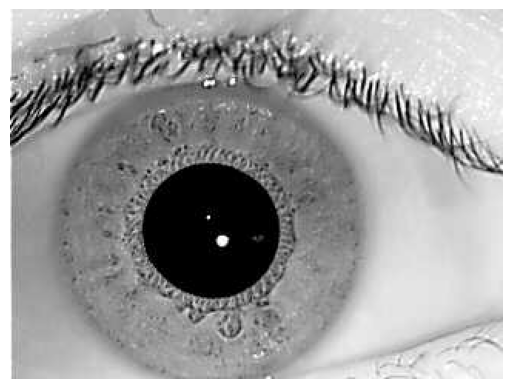

In [3]:
import cv2
import matplotlib.pyplot as plt
im1 = cv2.imread('/home/nishkal/dd/iris-code/datasets/IITD/001/01_L.bmp')

img_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [4]:
import os
import re

# Generate good pairs:
good_pairs = []
imposter_pairs = []

# Get all filenames
folder_path = 'datasets/IITD/Normalized_Images'
all_entries = os.listdir(folder_path)
filenames = [entry for entry in all_entries if os.path.isfile(os.path.join(folder_path, entry))]
for filename in filenames: 
    match = re.search(r'(\d+)_(\d+)\.bmp', filename)
    if match:
        user = match.group(1)
        img_no = match.group(2)
        #print(f"Filename: {filename}, Numbers: {user}, {img_no}")

print(len(filenames))


1120


Image Pairs - Good and Imposters

In [11]:
import itertools
import random
def generate_pairs(filenames, imposter_pairs_to_generate, seed =42):
    random.seed(seed)

    user_images ={}
    for filename in filenames:
        match = re.search(r'(\d+)_(\d+)\.bmp', filename)

        if match: 
            user = match.group(1)
            if user not in user_images:
                user_images[user] = []
            user_images[user].append(filename)
    
    users = list(user_images.keys())
    
    true_pairs = []
    imposter_pairs = []

    # Generate true pairs:

    for user in users:
        images = user_images[user]

        if len(images) >= 2:
            for pair in itertools.combinations(images,2):
                true_pairs.append(sorted(list(pair)))

    # Generate imposter pairs
    generated_pairs = set() # To check unique pairs

    for curr_user in users:
        other_users = [u for u in users if u != curr_user]

        if not other_users:
            continue
        
        anchor_image = random.choice(user_images[curr_user])
        imposter_pair_count = 0

        while imposter_pair_count < imposter_pairs_to_generate:
            imposter_user = random.choice(other_users)
            
            imposter_image = random.choice(user_images[imposter_user])
            
            pair = tuple(sorted([anchor_image, imposter_image]))
            
            # Use a set to check for and add unique pairs efficiently
            if pair not in generated_pairs:
                imposter_pairs.append(list(pair))
                generated_pairs.add(pair)
                imposter_pair_count += 1
    
    return true_pairs, imposter_pairs

In [13]:
imposter_pairs_per_user = 10
true_pairs, imposter_pairs = generate_pairs(filenames, imposter_pairs_per_user)
print(f"Some imposter pairs: {imposter_pairs[0:5]}")
print(f"Some true pairs: {true_pairs[0:5]}")
print(f"Total true pairs = {len(true_pairs)}, Total imposter pairs = {len(imposter_pairs)}")


Some imposter pairs: [['212_5.bmp', '216_4.bmp'], ['153_3.bmp', '216_4.bmp'], ['216_4.bmp', '219_5.bmp'], ['026_1.bmp', '216_4.bmp'], ['025_5.bmp', '216_4.bmp']]
Some true pairs: [['216_2.bmp', '216_4.bmp'], ['216_4.bmp', '216_5.bmp'], ['216_1.bmp', '216_4.bmp'], ['216_3.bmp', '216_4.bmp'], ['216_2.bmp', '216_5.bmp']]


 Gabor Wavelet Function

In [ ]:
import numpy as np 
import numpy as np
from scipy import ndimage as ndi
from skimage.util import view_as_blocks

def defined_gabor_kernel(frequency, sigma_x = None, sigma_y = None, n_stds = 3, offset = 0, theta = 0):
    x0 = np.ceil(max(np.abs(n_stds * sigma_x * np.cos(theta)),
                        np.abs(n_stds * sigma_y * np.sin(theta)), 1))
    y0 = np.ceil(max(np.abs(n_stds * sigma_y * np.cos(theta)),
                        np.abs(n_stds * sigma_x * np.sin(theta)), 1))
    y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y

    g *= (np.cos(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)) + 
        1j * np.sin(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)))
    #g *= np.exp(1j * 2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5))
    return g

def defined_gabor(img, frequency, sigma_x, sigma_y):
    g = defined_gabor_kernel(frequency, sigma_x, sigma_y)
    filtered_real = ndi.convolve(img, np.real(g), mode='wrap', cval=0)
    filtered_imag = ndi.convolve(img, np.imag(g), mode='wrap', cval=0)

    return filtered_real, filtered_imag

def getBitBlocks(filtered, size = 8):
    blocks = view_as_blocks(filtered, block_shape = (size,size)).reshape([-1,size**2])
    blocks = np.mean(blocks, axis = -1) - np.mean(filtered)
    return np.maximum(np.sign(blocks), 0)